# **Binary classification (COVID vs. No-Findings)**

Le notebook de l'article : [DarkCovidNet_for_binary_classes](https://github.com/muhammedtalo/COVID-19/blob/master/DarkCovidNet%20%20for%20binary%20classes.ipynb)

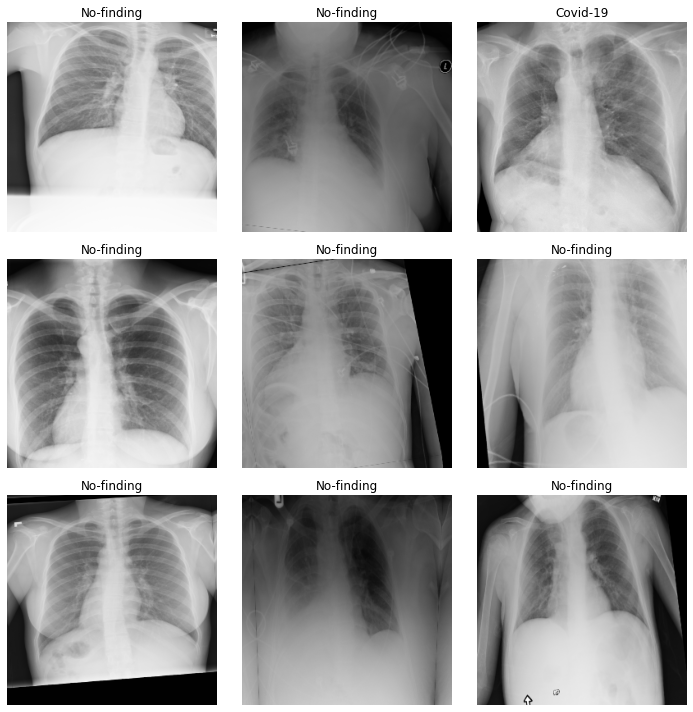

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Fastai** (Jeremy Howard et Rachel Thomas )   est une bibliothèque d'apprentissage en profondeur conçue comme une API de haut niveau au-dessus du framework **PyTorch**.


Fastai utilise des méthodes et des approches avancées d'apprentissage en profondeur pour générer des résultats de pointe.

 **vision** est un  module de la bibliothèque fastai contient toutes les fonctions nécessaires pour définir un Dataset et entraîner un modèle pour les tâches de vision par ordinateur. 

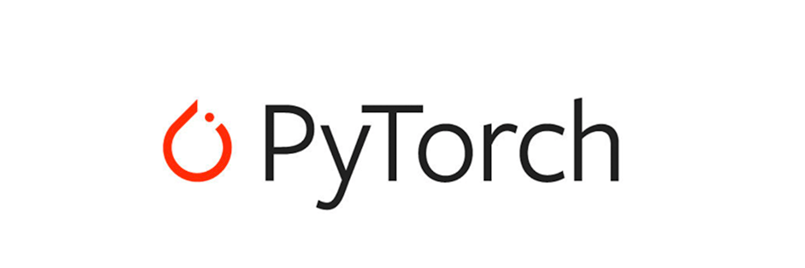

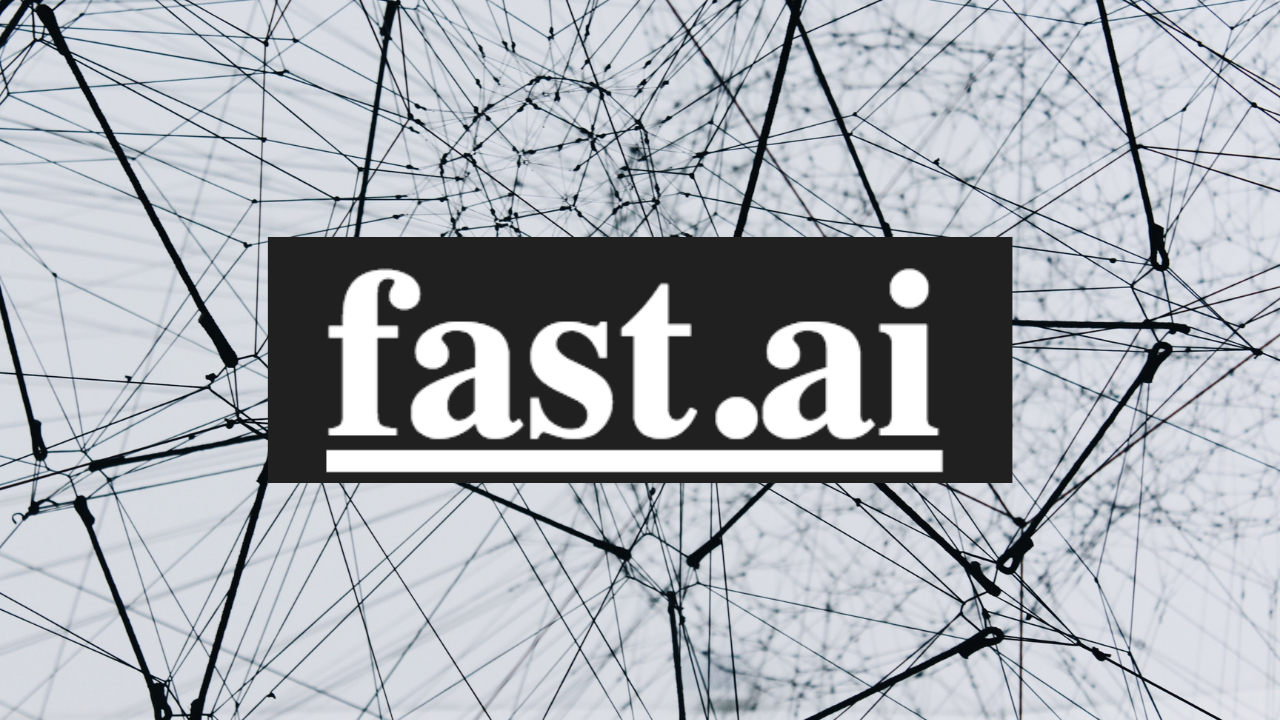

In [ ]:
from fastai.vision import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 0 : Importer Data

Créer l’ImageDataBunch (data) des données d’entraînement et de validation, c-à-d l’objet dans fastai qui regroupe le dataset et le dataloader de Pytorch ( fastai  est construit sur Pytorch). 

Dans ce travail , nous avons choisi la répartition des données comment suivant :

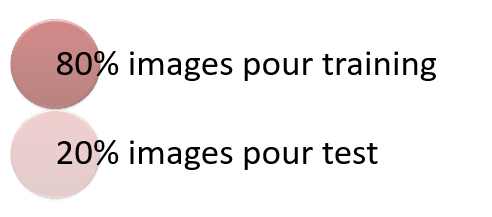

In [ ]:
data = ImageDataBunch.from_folder('/content/drive/MyDrive/data_DL', train='/content/drive/MyDrive/data_DL/train1', test='/content/drive/MyDrive/data_DL/valid1', valid_pct=0.2, ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_finding'], 2, 481, 120)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 481
Number of examples in validation: 120


Obtenir un batch de data :

In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

C1.PNG



*   Dans Pytorch , les objets sont définis sous fore de tensor (torch).
*  Torch une matrice multidimensionnelle contenant des éléments d'un seul type de données.

Ici, les images sont sous forme des matrices de taille 256*256 avec 3 canaux et la taille de chaque batch est 32

La fonction show_batch() permet d’afficher un batch d’images d’entraînement ou de validation pour vérification des transformations appliquées (les transformations seront appliquées aléatoirement et uniquement quand un batch sera appelé; ainsi une même image ne sera jamais présentée de manière identique au réseau lors de son entraînement).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

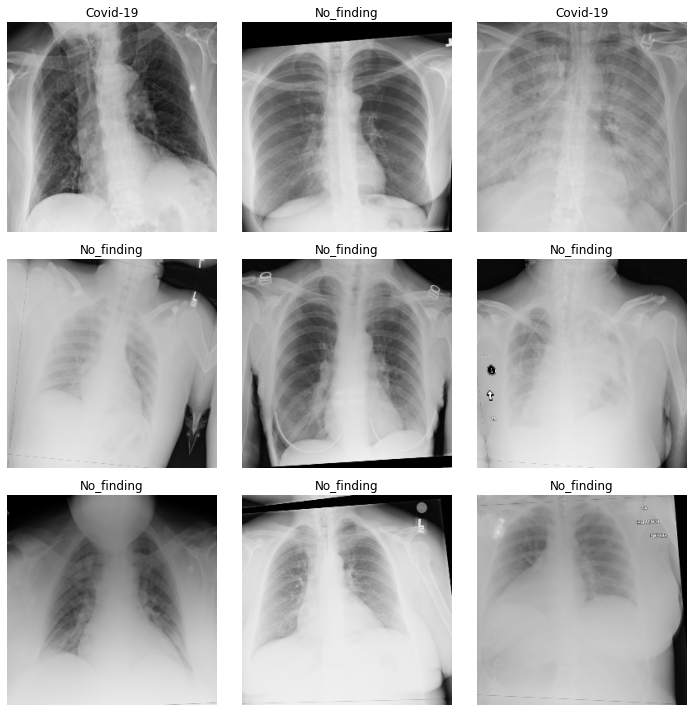

In [ ]:
#Sample images from the dataset
data.show_batch(rows=3, figsize=(10,10))

## Step 1 : DéfinirDarkCovidNet (modified Darknet model)

Dans cette étude , le modèle **Darknet-19** [[Redmon J. et al , 2017]](https://scholar.google.com/scholar?q=Redmon+J.+Farhadi+A.+Yolo9000:+Better,+Faster,+Stronger+2017+arXiv+preprint+)  est choisi comme point de départ. Darknet-19 est le modèle de classificateur qui constitue la base d'un système de détection d'objets en temps réel nommé YOLO (You only look once). 

Alors , **DarkCovidNet** est inspirée de l'architecture **DarkNet** qui a fait ses preuves en deep learning, au lieu de construire un modèle à partir de zéro.

Le modèle proposé (DarkCovidNet) comporte 17 couches de convolution :




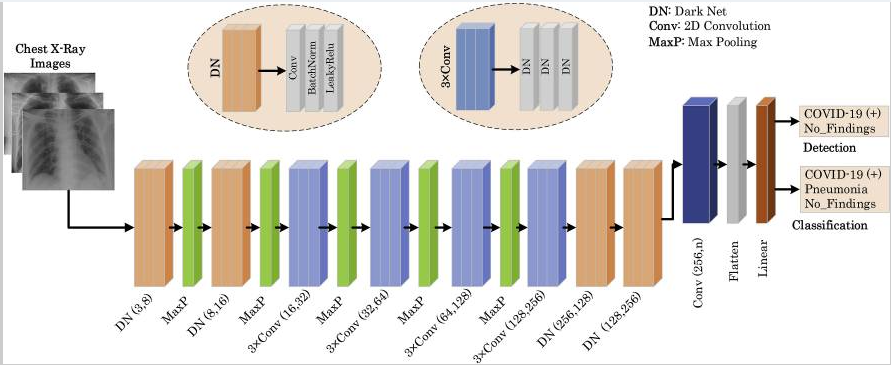



*   La couche DN (DarkNet) a une couche convolutive suivie des opérations BatchNorm et LeakyReLU :




In [ ]:
#Définir la couche DN :
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), # la couche de convolution
        nn.BatchNorm2d(nf), #l'opération e BatchNorm
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  # fonction d'activation
    )

Ensuite , définir un autre bloc (3 × Conv) qui a la même configuration trois fois sous forme successive :

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

La fonction Maxpool est utilisée dans toutes les opérations de pooling. Maxpool réduit la taille d'une entrée en prenant le maximum d'une région déterminée par son filtre :

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

Le nouveau modèle sea créer en rassemblant toutes  les fonctions définies ci-dessus : 

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
)

flatten() est ajouté à la fin pour avoir un vecteur de taille 2 (classification binaire ) 



Renvoyer tous cela à Learner() en transmettant les données, le modèle et la fonction de perte et la métrique "accuracy" :

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

Afficher les couches et les paramètres de couche du modèle :



*    Le modèle **DarkCovidNet** se compose de 1 164 434 paramètres.




In [ ]:
print(learn.summary())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________



1.   le taux d'apprentissage sélectionné comme 3e-3
2.   Le nombre d'époques est 100



In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

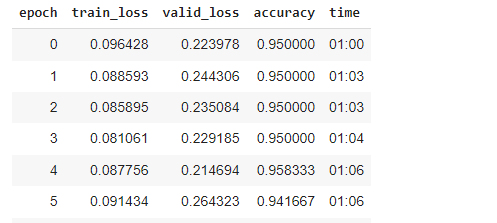

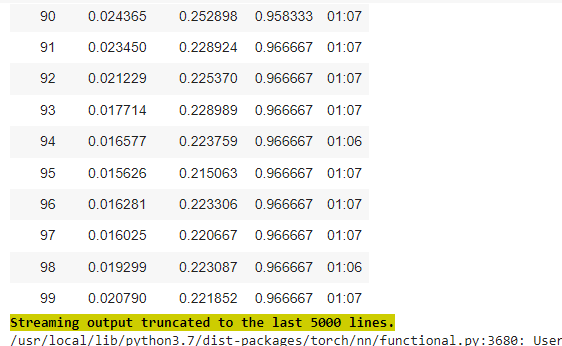

À partir de l'époque 90 , on remarque que "accuracy" de modèle commence à se stabiliser

In [ ]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 134


Afficher la précision de modèle :

In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

In [ ]:
accuracy(probs,targets)

tensor(0.9667)

## Step 2: Evaluer la performance de DarkCovidNet

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

120 116 0.9666666666666667
[[18  4]
 [ 0 98]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.82      0.90        22
 No_findings       0.96      1.00      0.98        98

    accuracy                           0.97       120
   macro avg       0.98      0.91      0.94       120
weighted avg       0.97      0.97      0.97       120



**Matrice de confucion :**

Une matrice de confusion est une matrice qui permet de mesurerla qualité d'un modèle de classification.Elle permet d'effectuer plus rapidement une analyse approfondie des prédictions et de faciliter la lecture des résultats grâce à une visualisation claire des données.



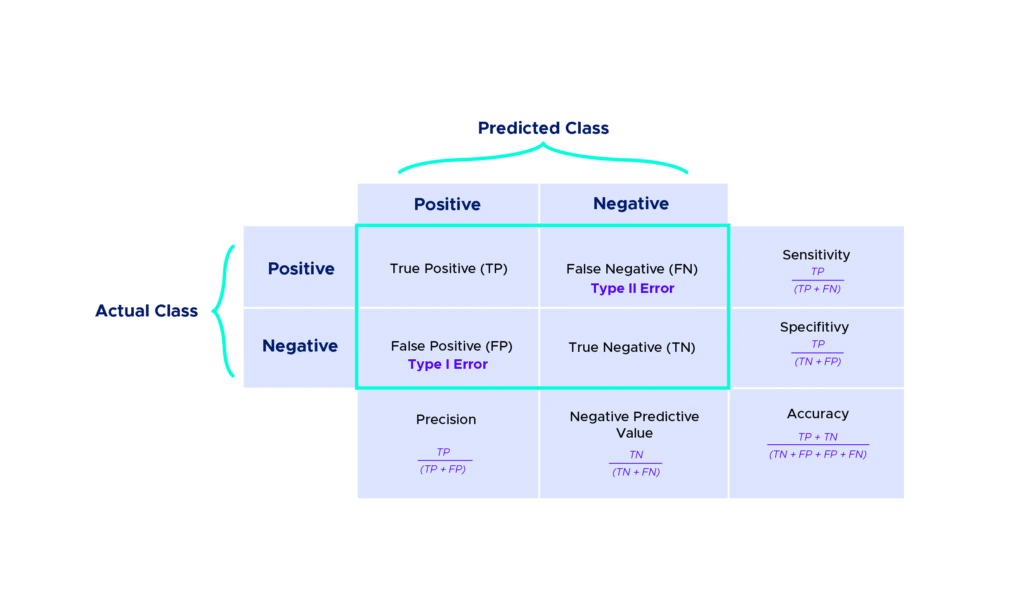

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

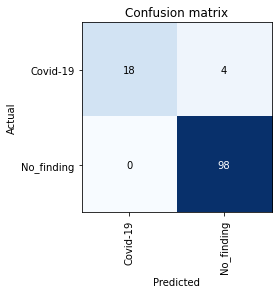

In [ ]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

On peut lire les données correctement prédites en regardant la diagonale de la matrice.


*   Ici , DarkCovidNet a détecté correctement 18 images de classe Covid-19 ,et 98 images de classe No_finding.
*   Le modèle a prédit 4 images dans la classe No_finding alors que ce sont des données de la classe Covid_19.On parle de faux positifs.
*  Le modèle n'a prédit aucune image de classe No_finding  comme une image de classe Covid_19.




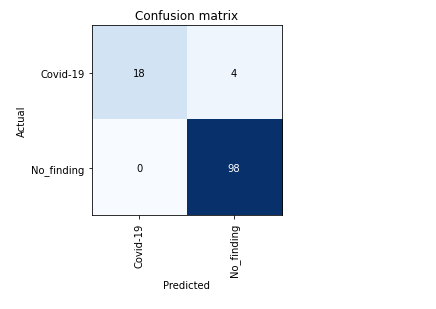